In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

# 설정 변수
SYMBOLS = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT']
file_path = '/home/zero/test1/full_csv'
seq_length = 20

# 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    X, X_symbol, y = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-4])  # 마지막 4개 컬럼 제외
        X_symbol.append(data[i+seq_length-1, -4:-1])  # 마지막 시퀀스의 심볼 정보만 추출
        y.append(data[i+seq_length, -1])  # 마지막 컬럼 (future_close)
    return np.array(X), np.array(X_symbol), np.array(y)

def calculate_sma(df, window):
    return df.rolling(window=window).mean()

def calculate_bollinger_bands(df, window):
    sma = df.rolling(window=window).mean()
    std = df.rolling(window=window).std()
    bollinger_up = sma + (std * 2)
    bollinger_down = sma - (std * 2)
    return bollinger_up, bollinger_down

# 학습, 검증, 테스트 데이터 및 심볼별 스케일러 저장
X_train_final, X_val_final, X_test_final = [], [], []
y_train_final, y_val_final, y_test_final = [], [], []
X_train_symbol_final, X_val_symbol_final, X_test_symbol_final = [], [], []
scalers_label_dict = {}

for symbol in SYMBOLS:
    csv_file_path = os.path.join(file_path, f"{symbol}.csv")
    df = pd.read_csv(csv_file_path)
    
    df = df[df['volume'] != 0]
    df['open_time'] = pd.to_datetime(df['open_time'])
    df.sort_values(by='open_time', inplace=True)
    df['future_close'] = df['close'].shift(-5)
    
    # SMA 및 볼린저 밴드 계산
    df['sma_20'] = calculate_sma(df['close'], 20)
    bollinger_up, bollinger_down = calculate_bollinger_bands(df['close'], 20)
    df['bollinger_up'] = bollinger_up
    df['bollinger_down'] = bollinger_down

    df.dropna(inplace=True)
    df.drop(columns=['open_time', 'quote_av', 'tb_base_av', 'tb_quote_av', 'trades'], inplace=True)
    
    # 원핫 인코딩
    for s in SYMBOLS:
        df[f'symbol_{s}'] = 1 if s == symbol else 0
    
    selected_columns = ['open', 'high', 'low', 'close', 'volume',  'sma_20', 'bollinger_up', 'bollinger_down',
                        'symbol_BTCUSDT', 'symbol_ETHUSDT', 'symbol_XRPUSDT', 'future_close']
    df = df[selected_columns]
    
    # 데이터 분리 (Train: 60%, Val+Test: 40%)
    df_train, df_val_test = train_test_split(df, test_size=0.4, shuffle=False)
    # 검증 및 테스트 데이터 분리 (각각 20%)
    df_val, df_test = train_test_split(df_val_test, test_size=0.5, shuffle=False)
    
    # 스케일링
    scaler_data = StandardScaler()
    scale_cols = ['open', 'high', 'low', 'close', 'volume', 'sma_20', 'bollinger_up', 'bollinger_down']
    df_train[scale_cols] = scaler_data.fit_transform(df_train[scale_cols])
    df_val[scale_cols] = scaler_data.transform(df_val[scale_cols])
    df_test[scale_cols] = scaler_data.transform(df_test[scale_cols])
    
    # # 스케일러 저장
    scaler_save_path = f'/home/zero/test1/회귀_preprocess_8(model)/scaler_data_{symbol}.save'
    joblib.dump(scaler_data, scaler_save_path)

    # 타겟 변수 스케일링 및 심볼별 스케일러 저장
    scaler_label = StandardScaler()
    df_train['future_close'] = scaler_label.fit_transform(df_train[['future_close']])
    df_val['future_close'] = scaler_label.transform(df_val[['future_close']])
    df_test['future_close'] = scaler_label.transform(df_test[['future_close']])
    scalers_label_dict[symbol] = scaler_label
    
    # # 스케일러 저장
    scaler_save_path = f'/home/zero/test1/회귀_preprocess_8(model)/scaler_target_{symbol}.save'
    joblib.dump(scaler_label, scaler_save_path)
    
    # 시퀀스 생성
    X_train, X_train_symbol, y_train = create_sequences(df_train.values, seq_length)
    X_val, X_val_symbol, y_val = create_sequences(df_val.values, seq_length)
    X_test, X_test_symbol, y_test = create_sequences(df_test.values, seq_length)
    
    # 데이터 저장
    X_train_final.extend(X_train)
    X_val_final.extend(X_val)
    X_test_final.extend(X_test)
    y_train_final.extend(y_train)
    y_val_final.extend(y_val)
    y_test_final.extend(y_test)
    X_train_symbol_final.extend(X_train_symbol)
    X_val_symbol_final.extend(X_val_symbol)
    X_test_symbol_final.extend(X_test_symbol)

In [2]:
# 배열 변환
X_train_final = np.array(X_train_final)
X_val_final = np.array(X_val_final)
X_test_final = np.array(X_test_final)
y_train_final = np.array(y_train_final)
y_val_final = np.array(y_val_final)
y_test_final = np.array(y_test_final)
X_train_symbol_final = np.array(X_train_symbol_final)
X_val_symbol_final = np.array(X_val_symbol_final)
X_test_symbol_final = np.array(X_test_symbol_final)

In [3]:
# 형태 확인
print(f"X_train_combined shape: {X_train_final.shape}")
print(f"X_train_symbol_combined shape: {X_val_final.shape}")
print(f"X_val_combined shape: {X_test_final.shape}")
print(f"X_val_symbol_combined shape: {X_train_symbol_final.shape}")
print(X_val_symbol_final.shape)
print(X_test_symbol_final.shape)

# 데이터 누락 또는 None 값 확인
datasets = [X_val_final, y_train_final, y_val_final, y_test_final, X_train_symbol_final, X_test_symbol_final]
names = ['X_train_combined', 'X_train_symbol_combined', 'X_val_combined', 'X_val_symbol_combined', 'y_train_combined', 'y_val_combined']

for data, name in zip(datasets, names):
    if data is None:
        print(f"{name} is None")
    elif isinstance(data, np.ndarray) and np.isnan(data).any():
        print(f"{name} contains NaN values")
    else:
        print(f"{name} is OK")


X_train_combined shape: (3032286, 20, 8)
X_train_symbol_combined shape: (1010721, 20, 8)
X_val_combined shape: (1010724, 20, 8)
X_val_symbol_combined shape: (3032286, 3)
(1010721, 3)
(1010724, 3)
X_train_combined is OK
X_train_symbol_combined is OK
X_val_combined is OK
X_val_symbol_combined is OK
y_train_combined is OK
y_val_combined is OK


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# 입력 및 정규화 매개변수
sequence_input_shape = (seq_length, 8)
symbol_input_shape = (3,)
l2_regularizer = l2(0.001)

# 시퀀스 입력
sequence_input = Input(shape=sequence_input_shape, name='sequence_input')
# CNN 레이어 확장
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2_regularizer)(sequence_input)
cnn = BatchNormalization()(cnn)
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2_regularizer)(cnn)

# LSTM 레이어 추가
lstm = LSTM(64, return_sequences=False, kernel_regularizer=l2_regularizer)(cnn)
lstm = Dropout(0.3)(lstm)

# 심볼 입력
symbol_input = Input(shape=symbol_input_shape, name='symbol_input')

# 시퀀스와 심볼 입력 결합
combined = Concatenate()([lstm, symbol_input])

# 더 깊은 네트워크 구성
combined = Dense(64, activation='relu', kernel_regularizer=l2_regularizer)(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.5)(combined)
combined = Dense(32, activation='relu', kernel_regularizer=l2_regularizer)(combined)
combined = Dropout(0.3)(combined)

# 출력 층
outputs = Dense(1)(combined)

# 모델 컴파일
model = Model(inputs=[sequence_input, symbol_input], outputs=outputs)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# 모델 요약 출력
model.summary()

2024-02-27 16:39:20.550365: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 16:39:22.554897: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 16:39:22.639670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 16:39:22.639726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been bu

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence_input (InputLayer  [(None, 20, 8)]              0         []                            
 )                                                                                                
                                                                                                  
 conv1d (Conv1D)             (None, 20, 64)               1600      ['sequence_input[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 20, 64)               256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                              

In [4]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath='/home/zero/test1/회귀_preprocess_8(model)/model_epoch_{epoch:02d}',  
    save_best_only=False, 
    save_weights_only=False, 
)

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,         
    verbose=1,          
    restore_best_weights=True 
)

history = model.fit(
    [X_train_final, X_train_symbol_final], 
    y_train_final,  
    epochs=20,
    batch_size=64,
    validation_data=([X_val_final, X_val_symbol_final], y_val_final), 
    callbacks=[early_stopping, model_checkpoint],
    verbose=1 
)

2024-02-27 16:39:27.264075: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1940661120 exceeds 10% of free system memory.
2024-02-27 16:39:30.853579: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1940661120 exceeds 10% of free system memory.


Epoch 1/20


2024-02-27 16:39:36.290473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-02-27 16:39:36.793744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-27 16:39:36.833306: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa2e6b076e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-27 16:39:36.833354: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-02-27 16:39:36.873428: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-27 16:39:37.089646: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

47380/47380 [==============================] - ETA: 0s - loss: 0.0796 - mae: 0.1693

2024-02-27 16:48:13.957322: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 646861440 exceeds 10% of free system memory.
2024-02-27 16:48:14.540649: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 646861440 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_01/assets


INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_01/assets


47380/47380 [==============================] - 588s 12ms/step - loss: 0.0796 - mae: 0.1693 - val_loss: 0.0094 - val_mae: 0.0493
Epoch 2/20
47378/47380 [============================>.] - ETA: 0s - loss: 0.0498 - mae: 0.1520INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_02/assets


INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_02/assets


47380/47380 [==============================] - 572s 12ms/step - loss: 0.0498 - mae: 0.1520 - val_loss: 0.0078 - val_mae: 0.0321
Epoch 3/20
47378/47380 [============================>.] - ETA: 0s - loss: 0.0491 - mae: 0.1510INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_03/assets


INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_03/assets


47380/47380 [==============================] - 580s 12ms/step - loss: 0.0491 - mae: 0.1510 - val_loss: 0.0120 - val_mae: 0.0760
Epoch 4/20
47379/47380 [============================>.] - ETA: 0s - loss: 0.0487 - mae: 0.1503INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_04/assets


INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_04/assets


47380/47380 [==============================] - 578s 12ms/step - loss: 0.0487 - mae: 0.1503 - val_loss: 0.0066 - val_mae: 0.0289
Epoch 5/20
47379/47380 [============================>.] - ETA: 0s - loss: 0.0485 - mae: 0.1500INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_05/assets


INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_05/assets


47380/47380 [==============================] - 586s 12ms/step - loss: 0.0485 - mae: 0.1500 - val_loss: 0.0094 - val_mae: 0.0563
Epoch 6/20
47380/47380 [==============================] - ETA: 0s - loss: 0.0482 - mae: 0.1493INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_06/assets


INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_06/assets


47380/47380 [==============================] - 549s 12ms/step - loss: 0.0482 - mae: 0.1493 - val_loss: 0.0072 - val_mae: 0.0364
Epoch 7/20
47375/47380 [============================>.] - ETA: 0s - loss: 0.0479 - mae: 0.1488INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_07/assets


INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_07/assets


47380/47380 [==============================] - 555s 12ms/step - loss: 0.0479 - mae: 0.1488 - val_loss: 0.0093 - val_mae: 0.0546
Epoch 8/20
47376/47380 [============================>.] - ETA: 0s - loss: 0.0479 - mae: 0.1489INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_08/assets


INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_08/assets


47380/47380 [==============================] - 555s 12ms/step - loss: 0.0479 - mae: 0.1489 - val_loss: 0.0079 - val_mae: 0.0474
Epoch 9/20
47379/47380 [============================>.] - ETA: 0s - loss: 0.0477 - mae: 0.1486Restoring model weights from the end of the best epoch: 4.
INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_09/assets


INFO:tensorflow:Assets written to: /home/zero/test1/회귀_preprocess_8(model)/model_epoch_09/assets


47380/47380 [==============================] - 564s 12ms/step - loss: 0.0477 - mae: 0.1486 - val_loss: 0.0095 - val_mae: 0.0611
Epoch 9: early stopping


In [ ]:
# 학습 과정 시각화를 위한 기본적인 그래프
import matplotlib.pyplot as plt

# 손실 그래프
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도, 메트릭이 정의되어 있다면 그래프로 표현 가능
if 'mae' in history.history:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.show()

In [1]:
from keras.models import load_model

# 모델이 저장된 경로를 정의합니다. (예시: 'model_epoch_10'과 같이 epoch 번호를 포함)
model_path = '/home/zero/test1/회귀_preprocess_8(model)/model_epoch_04'

# 모델을 불러옵니다. '{epoch:02d}' 부분은 실제 epoch 번호로 대체해야 합니다.
loaded_model = load_model(model_path)

# 불러온 모델을 '.h5' 형식으로 저장합니다.
# 'model_epoch_{epoch:02d}.h5' 부분에 원하는 파일명을 사용하세요.
loaded_model.save('/home/zero/test1/회귀_preprocess_8(model)/model_epoch_04.h5')


2024-03-02 23:23:26.930660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-02 23:23:29.164074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-02 23:23:29.250739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-02 23:23:29.250818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been bu

In [11]:
from tensorflow.keras.utils import plot_model
from keras import layers, models
plot_model(loaded_model, show_shapes=True, to_file='/home/zero/test1/회귀_preprocess_8(model)/model1.png')


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [5]:
from tensorflow.keras.models import load_model

model_path = '/home/zero/test1/회귀_preprocess_8(model)/model_epoch_04'
model = load_model(model_path)

In [4]:
# 첫 번째 절반의 인덱스 계산
first_half_index = len(X_train_final) // 2

# 두 번째 절반의 시작 인덱스는 첫 번째 절반의 끝 인덱스
second_half_index = first_half_index

# 데이터를 절반으로 나누기
X_train_final_first_half = X_train_final[:first_half_index]
X_train_symbol_final_first_half = X_train_symbol_final[:first_half_index]

X_train_final_second_half = X_train_final[second_half_index:]
X_train_symbol_final_second_half = X_train_symbol_final[second_half_index:]

In [5]:
predictions_train_1 = model.predict([X_train_final_first_half, X_train_symbol_final_first_half])

2024-02-27 12:01:54.741939: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 970331520 exceeds 10% of free system memory.
2024-02-27 12:01:55.667890: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 970331520 exceeds 10% of free system memory.
2024-02-27 12:01:56.354787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907


   49/47380 [..............................] - ETA: 2:37

2024-02-27 12:01:56.764787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


47380/47380 [==============================] - 141s 3ms/step


In [6]:
predictions_train_2 = model.predict([X_train_final_second_half, X_train_symbol_final_second_half])

2024-02-27 12:09:43.414878: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 970331520 exceeds 10% of free system memory.
2024-02-27 12:09:44.250952: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 970331520 exceeds 10% of free system memory.


47380/47380 [==============================] - 139s 3ms/step


In [7]:
predictions_train = np.concatenate([predictions_train_1, predictions_train_2], axis=0)

In [8]:
# 모델을 사용하여 검증 데이터에 대한 예측을 수행
predictions_val = model.predict([X_val_final, X_val_symbol_final])

2024-02-27 12:16:57.898996: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 646861440 exceeds 10% of free system memory.


31586/31586 [==============================] - 98s 3ms/step


In [6]:
predictions_test = model.predict([X_test_final, X_test_symbol_final])

2024-02-27 18:06:35.325842: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 646861440 exceeds 10% of free system memory.


31586/31586 [==============================] - 91s 3ms/step


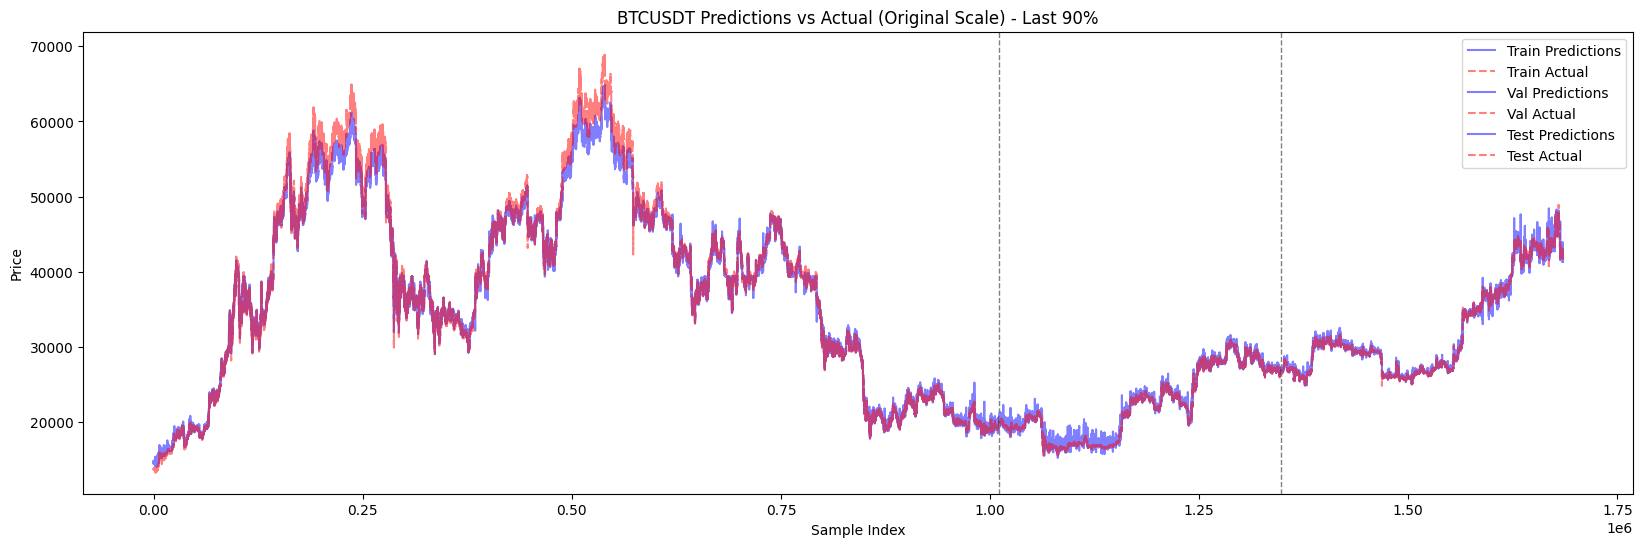

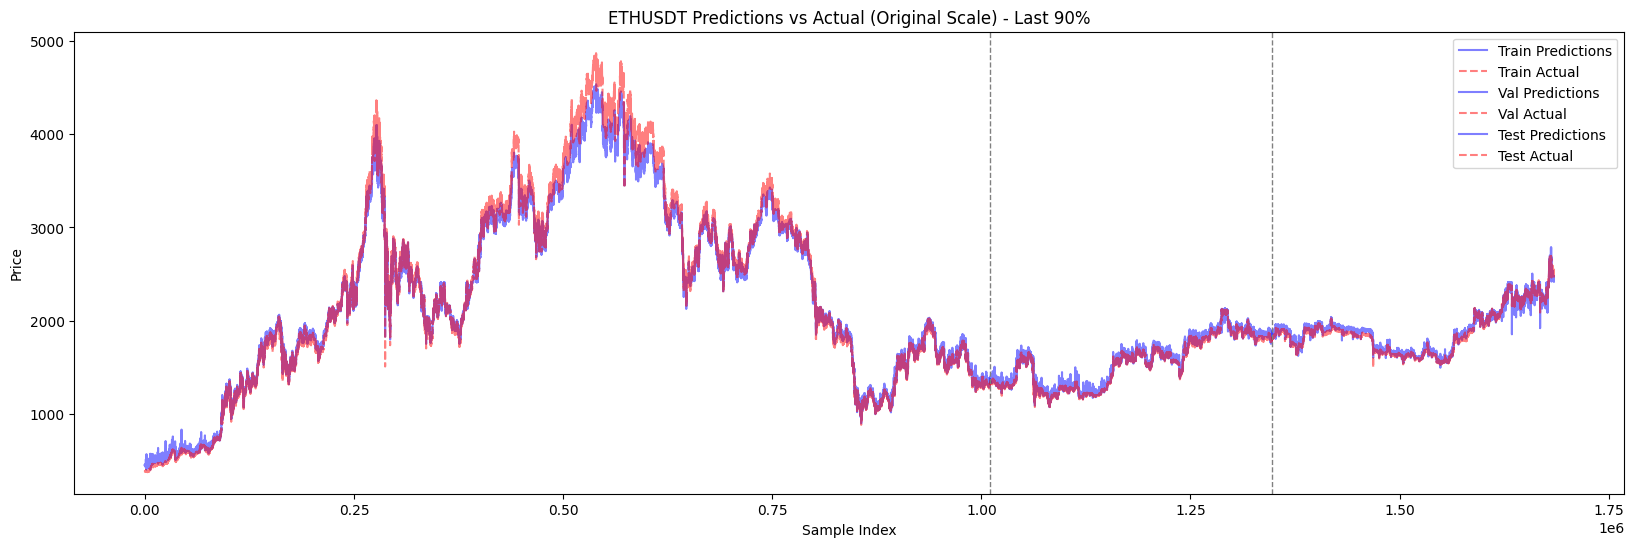

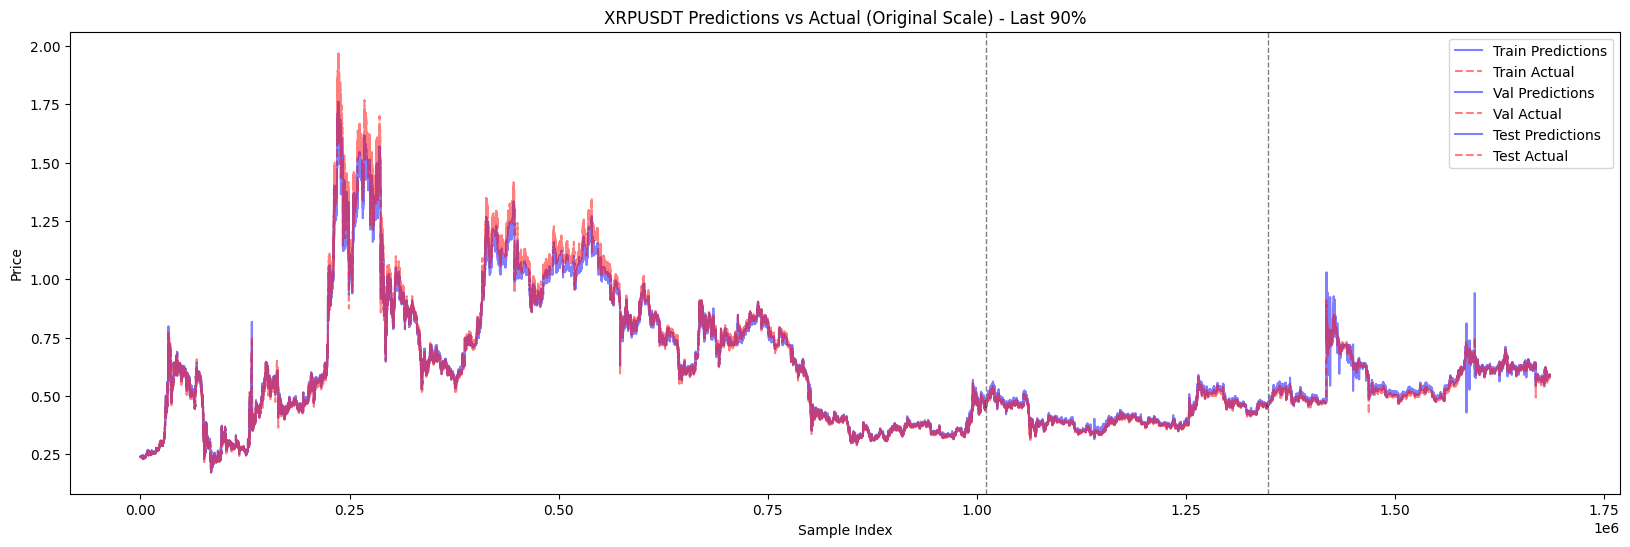

In [10]:
import matplotlib.pyplot as plt

# 원하는 데이터 범위 설정 (예: 전체 데이터의 40%)
data_range_percent = 90

# 각 심볼별로 그래프 그리기
for symbol in SYMBOLS:
    # 심볼별 인덱스 추출
    train_indices = np.where(X_train_symbol_final[:, SYMBOLS.index(symbol)] == 1)[0]
    val_indices = np.where(X_val_symbol_final[:, SYMBOLS.index(symbol)] == 1)[0]
    test_indices = np.where(X_test_symbol_final[:, SYMBOLS.index(symbol)] == 1)[0]
    
    # 심볼별 예측값과 실제값 역변환
    scaler_label = scalers_label_dict[symbol]
    predictions_train_inverse = scaler_label.inverse_transform(predictions_train[train_indices].reshape(-1, 1)).flatten()
    y_train_inverse = scaler_label.inverse_transform(y_train_final[train_indices].reshape(-1, 1)).flatten()
    predictions_val_inverse = scaler_label.inverse_transform(predictions_val[val_indices].reshape(-1, 1)).flatten()
    y_val_inverse = scaler_label.inverse_transform(y_val_final[val_indices].reshape(-1, 1)).flatten()
    predictions_test_inverse = scaler_label.inverse_transform(predictions_test[test_indices].reshape(-1, 1)).flatten()
    y_test_inverse = scaler_label.inverse_transform(y_test_final[test_indices].reshape(-1, 1)).flatten()

    # 데이터의 지정된 범위만 선택
    total_length = len(predictions_train_inverse) + len(predictions_val_inverse) + len(predictions_test_inverse)
    start_index = int(total_length * (100 - data_range_percent) / 100)
    
    # 전체 인덱스 범위 계산
    total_indices = np.arange(total_length)
    
    # 그래프 그리기
    plt.figure(figsize=(20, 6))
    train_end_index = len(predictions_train_inverse)
    val_end_index = train_end_index + len(predictions_val_inverse)
    
    plt.plot(total_indices[:train_end_index], predictions_train_inverse, label='Train Predictions', color='blue', alpha=0.5)
    plt.plot(total_indices[:train_end_index], y_train_inverse, label='Train Actual', color='red', alpha=0.5, linestyle='dashed')
    plt.plot(total_indices[train_end_index:val_end_index], predictions_val_inverse, label='Val Predictions', color='blue', alpha=0.5)
    plt.plot(total_indices[train_end_index:val_end_index], y_val_inverse, label='Val Actual', color='red', alpha=0.5, linestyle='dashed')
    plt.plot(total_indices[val_end_index:], predictions_test_inverse, label='Test Predictions', color='blue', alpha=0.5)
    plt.plot(total_indices[val_end_index:], y_test_inverse, label='Test Actual', color='red', alpha=0.5, linestyle='dashed')
    
    # 학습, 검증, 테스트 데이터 구분선 추가
    plt.axvline(x=train_end_index-0.5, color='grey', linestyle='--', linewidth=1)
    plt.axvline(x=val_end_index-0.5, color='grey', linestyle='--', linewidth=1)
    
    plt.title(f'{symbol} Predictions vs Actual (Original Scale) - Last {data_range_percent}%')
    plt.xlabel('Sample Index')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


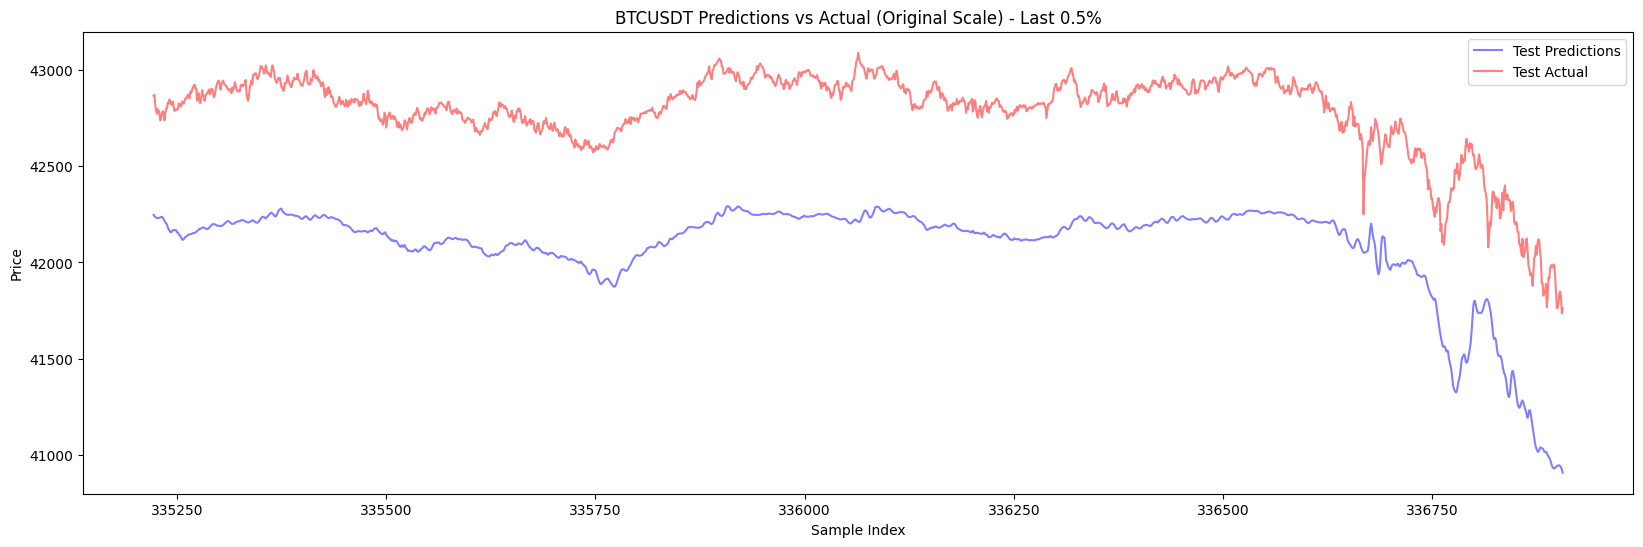

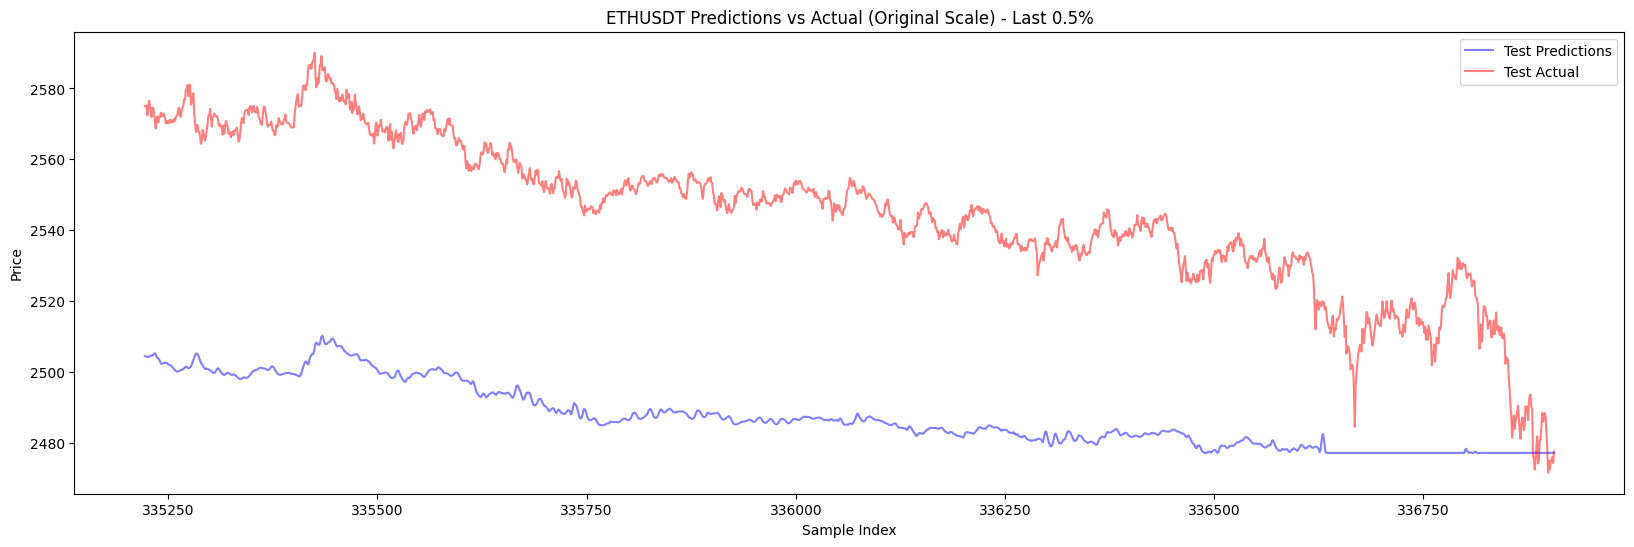

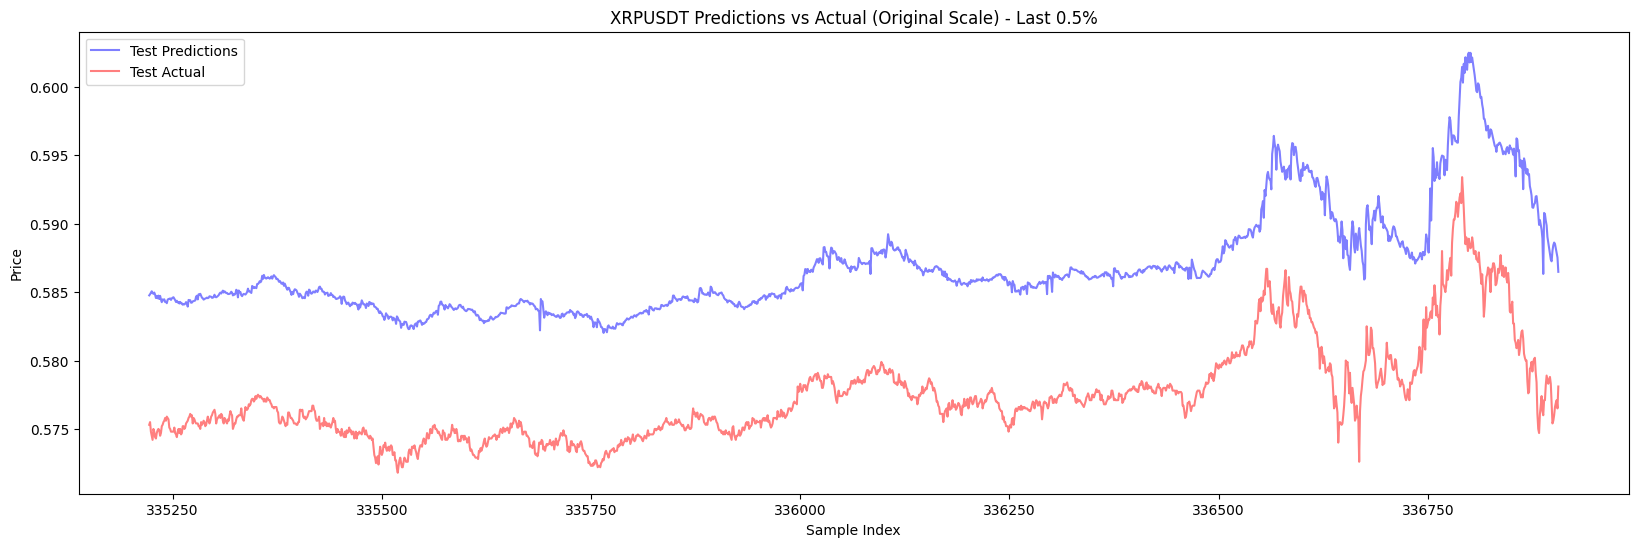

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 원하는 데이터 범위 설정 (예: 전체 데이터의 90%)
data_range_percent = 0.5

# 각 심볼별로 그래프 그리기
for symbol in SYMBOLS:
    # 심볼별 인덱스 추출
    test_indices = np.where(X_test_symbol_final[:, SYMBOLS.index(symbol)] == 1)[0]
    
    # 심볼별 예측값과 실제값 역변환
    scaler_label = scalers_label_dict[symbol]
    predictions_test_inverse = scaler_label.inverse_transform(predictions_test[test_indices].reshape(-1, 1)).flatten()
    y_test_inverse = scaler_label.inverse_transform(y_test_final[test_indices].reshape(-1, 1)).flatten()

    # 데이터의 지정된 범위만 선택
    total_length = len(predictions_test_inverse)
    start_index = int(total_length * (100 - data_range_percent) / 100)
    
    # 전체 인덱스 범위 계산
    total_indices = np.arange(total_length)
    
    # 그래프 그리기
    plt.figure(figsize=(20, 6))
    plt.plot(total_indices[start_index:], predictions_test_inverse[start_index:], label='Test Predictions', color='blue', alpha=0.5)
    plt.plot(total_indices[start_index:], y_test_inverse[start_index:], label='Test Actual', color='red', alpha=0.5)
    
    plt.title(f'{symbol} Predictions vs Actual (Original Scale) - Last {data_range_percent}%')
    plt.xlabel('Sample Index')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

base_path = '/home/zero/test1/회귀_preprocess_8(model)/'

# base_path 내의 파일 리스트 가져오기
all_files = os.listdir(base_path)

# 'model_epoch'으로 시작하는 파일들만 선택
model_files = [file for file in all_files if file.startswith('model_epoch')]

# 파일명에서 숫자 부분 추출하여 정렬을 위한 키로 사용
model_files_sorted = sorted(model_files, key=lambda x: int(x.split('_')[2]))

for model_file in model_files_sorted:
    model_path = os.path.join(base_path, model_file)
    model = load_model(model_path)
    predictions_test = model.predict([X_test_final, X_test_symbol_final])

    # 원하는 데이터 범위 설정 (예: 전체 데이터의 90%)
    data_range_percent = 1

    # 각 심볼별로 그래프 그리기
    for symbol in SYMBOLS:
        # 심볼별 인덱스 추출
        test_indices = np.where(X_test_symbol_final[:, SYMBOLS.index(symbol)] == 1)[0]
        
        # 심볼별 예측값과 실제값 역변환
        scaler_label = scalers_label_dict[symbol]
        predictions_test_inverse = scaler_label.inverse_transform(predictions_test[test_indices].reshape(-1, 1)).flatten()
        y_test_inverse = scaler_label.inverse_transform(y_test_final[test_indices].reshape(-1, 1)).flatten()

        # 데이터의 지정된 범위만 선택
        total_length = len(predictions_test_inverse)
        start_index = int(total_length * (100 - data_range_percent) / 100)
        
        # 전체 인덱스 범위 계산
        total_indices = np.arange(total_length)
        
        # 그래프 그리기
        plt.figure(figsize=(20, 6))
        plt.plot(total_indices[start_index:], predictions_test_inverse[start_index:], label='Test Predictions', color='blue', alpha=0.5)
        plt.plot(total_indices[start_index:], y_test_inverse[start_index:], label='Test Actual', color='red', alpha=0.5)
        
        plt.title(f'{symbol} Predictions vs Actual ({model_file}) - Last {data_range_percent}%')
        plt.xlabel('Sample Index')
        plt.ylabel('Price')
        plt.legend()
        plt.show()



In [19]:
print(predictions_test)

[[-0.9075614 ]
 [-0.9070875 ]
 [-0.90796965]
 ...
 [-0.34884128]
 [-0.34327608]
 [-0.34311533]]


In [21]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-02-23 16:22:48.469550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 16:22:50.877911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-23 16:22:50.896292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-23 16:22:50.896389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been bu